In [26]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib
import math
import os 
import torch.nn.functional as F

import importlib
import data_analysis
importlib.reload(data_analysis)

import utils
importlib.reload(utils)

%matplotlib inline
matplotlib.pyplot.rc('text', usetex=True)
fontsize = 18


print(f'Working in {os.getcwd()}')

Working in /projects/IceDynamics/Stage_M2/code


In [2]:
from utils import get_freer_gpu

device = get_freer_gpu() if torch.cuda.is_available() else "cpu"

Selected GPU 0 with 24197 MB free memory 


In [3]:
class SimuDataset(Dataset):

    def __init__(self, simu, rgb = False, transform = None):
        X = simu.X
        if rgb : 
            X = simu.X_rgb
        self.x = torch.from_numpy(X).to(device)
        self.n_snapshots = X.shape[1]
        self.transform = transform
        self.rgb = rgb
        
    def __getitem__(self, index):
        sample = self.x[:,index]
        t = index
        
        if self.transform:
            sample = self.transform(sample)
        if self.rgb:
            sample = self.x[:,index, :, :]
        return sample, t 
    
    def __len__(self):
        return self.n_snapshots
    

class LinearAutoencoder(nn.Module):
    def __init__(self, n_channels, N):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_channels*N, 128*16), 
            nn.ReLU(), 
            nn.Linear(128*16, 64*16), 
            nn.ReLU(), 
            nn.Linear(64*16, 12*16))
        
        self.decoder = nn.Sequential(
            nn.Linear(12*16, 64*16), 
            nn.ReLU(), 
            nn.Linear(64*16, 128*16), 
            nn.ReLU(), 
            nn.Linear(128*16, n_channels*N),
            nn.Tanh())
        
    def forward(self, x):
        # print(f'size of x {x.shape}')
        x = x.float()
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



In [4]:
from data_analysis import Simulation
from data_analysis import compatible_path
current_directory = compatible_path('../')

simulation = Simulation(current_directory, normalize = True)
time, x, z, u, w, T, umean, wmean, Tmean = map(lambda x: torch.tensor(x).to(device), simulation.import_data())
simulation.image_rgb()

h, l = np.shape(x)
m = len(time)
print(m)
N = h*l*3

6249


# Simple Linear Autoencoder

## Running algo

In [5]:
class SimpleLinearAutoencoder(nn.Module):
    def __init__(self, N, K = 20, device = device):
        super().__init__()
        self.encoder = nn.Linear(N, K).to(device)
        
        self.decoder = nn.Sequential(
            nn.Linear(K, N), 
            nn.Tanh()).to(device)
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [21]:
batch_size = 4
K = 128

dataset = SimuDataset(simulation)
first = dataset[0]
dataloader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True)

dataiter = iter(dataloader)
data, t = next(dataiter)
print(t)
print(torch.min(data), torch.max(data), data.shape)

model = SimpleLinearAutoencoder(N, K, device = device)
model.to(device) 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

tensor([3256, 1279, 2039, 5956])
tensor(-0.6998, device='cuda:0', dtype=torch.float64) tensor(0.7316, device='cuda:0', dtype=torch.float64) torch.Size([4, 12393])


In [22]:
num_epoch = 9
output = []
for epoch in range(num_epoch):
    for map, t in dataloader:
        map = map.float().to(device)
        reconstructed = model(map)
        loss = criterion(reconstructed, map)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch+1}, Loss:{loss.item() : .4f}")
    output.append((epoch, int(t),  map, reconstructed))

Epoch: 1, Loss: 0.0045
Epoch: 2, Loss: 0.0049
Epoch: 3, Loss: 0.0079
Epoch: 4, Loss: 0.0035
Epoch: 5, Loss: 0.0173
Epoch: 6, Loss: 0.0051
Epoch: 7, Loss: 0.0048
Epoch: 8, Loss: 0.0098
Epoch: 9, Loss: 0.0072


#### saving

In [23]:
torch.save(model.state_dict(), f'{current_directory}/results/autoencoder/simple_linear/model_K{K}.pt')

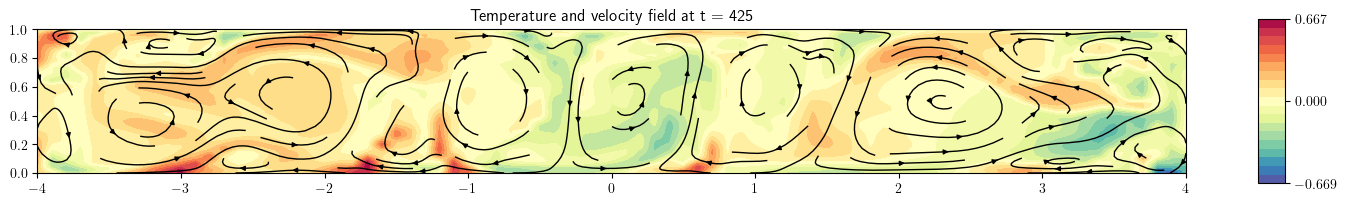

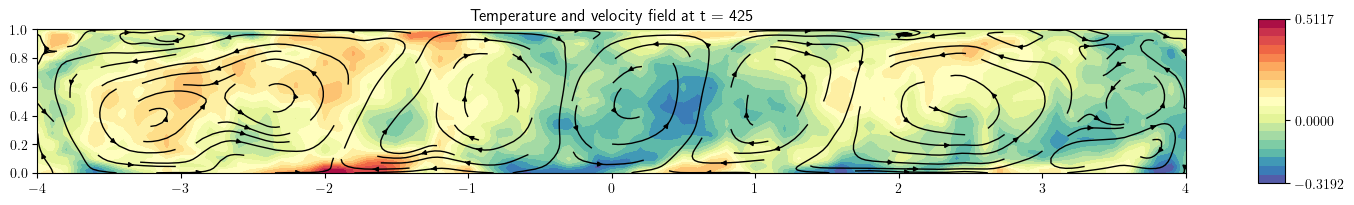

In [24]:
from utils import plot_field
epoch = 8

t = output[epoch][1]
field = np.reshape(np.array(output[epoch][2].cpu()), N)
reconstructed = output[epoch][3].cpu()
reconstructed = np.reshape(reconstructed.detach().numpy(), N)

plot_field(simulation, np.reshape(field[:h*l], (h, l)), np.reshape(field[h*l:2*h*l], (h,l)), np.reshape(field[2*h*l:], (h, l)), t)
plot_field(simulation, np.reshape(reconstructed[:h*l], (h, l)), np.reshape(reconstructed[h*l:2*h*l], (h,l)), np.reshape(reconstructed[2*h*l:], (h, l)), t)

## Analysis

In [13]:
K = 50
# encoder = torch.load(f'{current_directory}/results/autoencoder/simple_linear/encoder.pt')
# decoder = torch.load(f'{current_directory}/results/autoencoder/simple_linear/decoder.pt')
model = torch.load(f'{current_directory}/results/autoencoder/simple_linear/model_K{K}.pt')

In [26]:
weights = model.encoder.cpu().weight.data
U = weights.numpy()

# weights_R = model.decoder.cpu().weight
# R = weights_R.numpy()
print(U.shape)

(128, 12393)


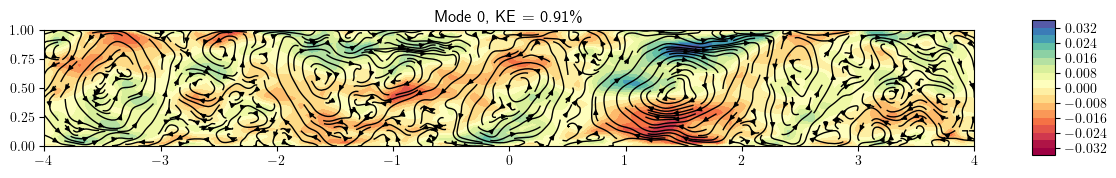

In [29]:
n_mode = 0

KE = np.sum(np.abs(U), axis = 1)/np.sum(np.abs(U))
sorting_indexes = np.argsort(KE)[::-1]

u_modes = np.reshape(np.swapaxes(U[:,:h*l], 0,1), (h, l, K))[:,:,sorting_indexes]
w_modes = np.reshape(np.swapaxes(U[:,h*l:2*h*l], 0, 1), (h, l, K))[:,:,sorting_indexes]
T_modes = np.reshape(np.swapaxes(U[:,2*h*l:], 0, 1), (h, l, K))[:,:,sorting_indexes]

from POD import streamplot_mode

streamplot_mode(u_modes, w_modes, u_modes, KE[sorting_indexes], n_mode, simulation.x, simulation.z)

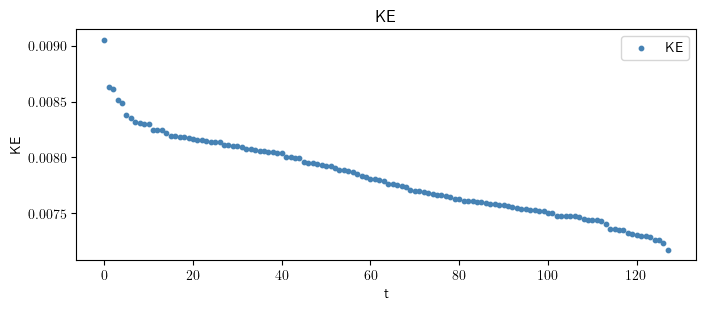

In [31]:
fig,ax = plt.subplots(figsize = (8, 3))

ax.scatter(range(len(KE)), KE[sorting_indexes], s = 10, c = 'steelblue', label = 'KE')
ax.set_title('KE')
ax.set_ylabel('KE')
ax.set_xlabel('t')
ax.legend()
# fig.tight_layout()
plt.show()

In [32]:
X = simulation.X.T
x = torch.from_numpy(X)
x = x.float()
print(x.shape)
print(x.T.shape)
print(x[0].shape)

torch.Size([6249, 12393])
torch.Size([12393, 6249])
torch.Size([12393])


In [38]:
K = 50
autoencoder = SimpleLinearAutoencoder(N, K, device)

autoencoder.load_state_dict(torch.load(f'{current_directory}/results/autoencoder/simple_linear/model_K{K}.pt'))
autoencoder.eval()  # Set the model to evaluation mode


with torch.no_grad():
    encoded_data = autoencoder.encoder(x.to(device))

with torch.no_grad():
    decoded_data = autoencoder.decoder(encoded_data)

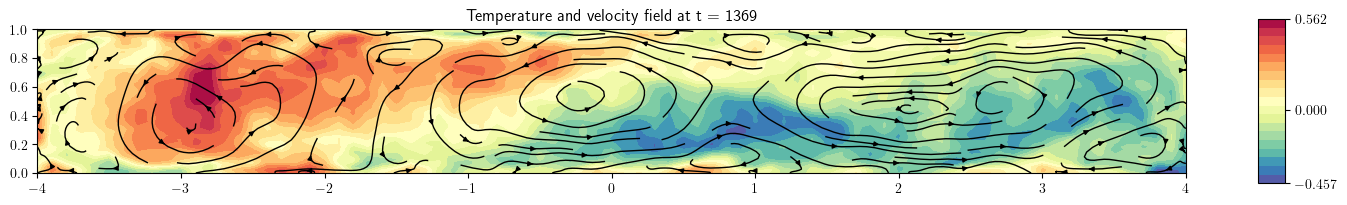

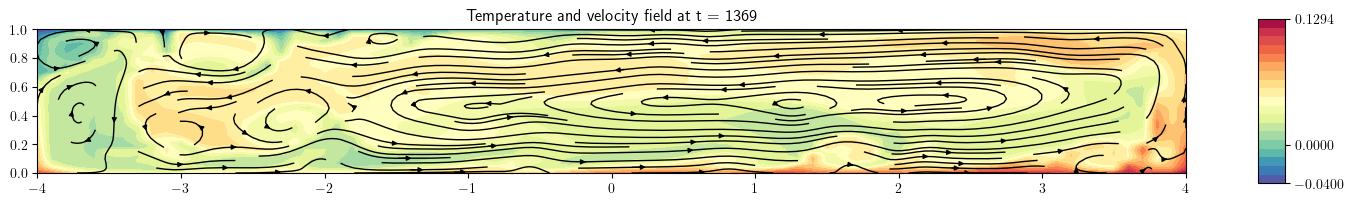

In [39]:
from data_analysis import Simulation
decoded_simulation = Simulation(current_directory, normalize = True)
decoded_simulation.reconstruct_simulation(decoded_data.cpu().numpy())

t = 1369
decoded_simulation.plot_field(t)
simulation.plot_field(t)

In [40]:
decoded_simulation.save_clip(1350, 1400, f'{current_directory}/results/autoencoder/simple_linear/snapshots/')

In [41]:
from utils import make_gif

make_gif(f'{current_directory}/results/autoencoder/simple_linear/snapshots/', f'{current_directory}/results/gif/linear_ae_decoded_field_K{K}.gif', 10)

GIF created at: ..//results/autoencoder/simple_linear/snapshots/linear_ae_decoded_field_K50.gif


# CNN

## Algo

In [8]:
import torch.nn.functional as F
size1 = (20, 12)
size2 = (10, 6)
size3 = (3, 2)

class ConvolutionalAutoencoder(nn.Module):

    def __init__(self, device, n_channels = 64, kernel_size = 3, stride = 1, padding = 1, bias = True):
        super().__init__()
        #shape : B * 3 * 81 * 51
        self.encoder = nn.Sequential(
            nn.Conv2d(3, n_channels//2, kernel_size, stride = stride, padding = padding, bias = bias), 
            nn.ReLU(), 
            nn.Upsample(size=size1, mode='bilinear', align_corners=False), 
            nn.Conv2d(n_channels//2, n_channels, kernel_size, stride = stride, padding = padding, bias = bias),
            nn.ReLU(),
            nn.Upsample(size=size2, mode='bilinear', align_corners=False), 
            nn.Conv2d(n_channels, n_channels, kernel_size, stride = stride, padding = padding, bias = bias), 
            nn.ReLU(),
            nn.Upsample(size=size3, mode='bilinear', align_corners=False)).to(device)
        
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(n_channels, n_channels//2, kernel_size, stride = stride, padding = padding, bias = bias), 
            nn.ReLU(), 
            nn.Upsample(size=size2, mode='bilinear', align_corners=False), 
            nn.ConvTranspose2d(n_channels//2, n_channels, kernel_size, stride = stride, padding = padding, bias = bias),
            nn.ReLU(),
            nn.Upsample(size=size1, mode='bilinear', align_corners=False), 
            nn.ConvTranspose2d(n_channels, 3, kernel_size, stride = stride, padding = padding, bias = bias), 
            nn.Upsample(size=(81, 51), mode='bilinear', align_corners=False)).to(device)
        
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [6]:
batch_size = 4

dataset = SimuDataset(simulation, rgb = True)
first = dataset[0]
dataloader = DataLoader(dataset = dataset, batch_size = batch_size)

dataiter = iter(dataloader)
data, t = next(dataiter)
print(torch.min(data), torch.max(data), data.shape)

model = ConvolutionalAutoencoder(device = device)
model.to(device) 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

tensor(-0.6562, device='cuda:0', dtype=torch.float64) tensor(0.5647, device='cuda:0', dtype=torch.float64) torch.Size([4, 3, 81, 51])


In [7]:
num_epoch = 5
output = []
info = []
for epoch in range(num_epoch):
    for map, t in dataloader:
        map = map.float().to(device)
        reconstructed = model(map)
        loss = criterion(reconstructed, map)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch+1}, Loss:{loss.item() : .4f}")
    info.append((epoch, loss.item()))
    output.append((epoch, map, reconstructed))

Epoch: 1, Loss: 0.0123
Epoch: 2, Loss: 0.0092
Epoch: 3, Loss: 0.0086
Epoch: 4, Loss: 0.0074
Epoch: 5, Loss: 0.0065


In [8]:
def info_text(directory, batch_size, size1, size2, size3, num_epoch, info):
    with open(directory + f"model_bs{batch_size}_info.txt", 'w') as file:
        file.write(f"Information about Convolutionnal Autoencoder with batch size {batch_size}\n")
        file.write(f"size1 = {size1}\n")
        file.write(f"size2 = {size2}\n")
        file.write(f"size3 = {size3}\n")
        file.write(f"num epoch = {num_epoch}\n")
        for i in range(len(info)):
            file.write(f"epoch {info[i][0]}, loss {info[i][1]}\n")

In [11]:
len(info)

5

In [9]:
directory = f'{current_directory}/results/autoencoder/cnn/'
torch.save(model.state_dict(), directory + f'model_bs{batch_size}.pt')
info_text(directory, batch_size, size1, size2, size3, num_epoch, info)

In [23]:
batch_size = 4

dataset = SimuDataset(simulation, rgb = True)
first = dataset[0]
dataloader = DataLoader(dataset = dataset, batch_size = batch_size)

dataiter = iter(dataloader)
data = next(dataiter)
print(torch.min(data), torch.max(data), data.shape)

model = ConvolutionalAutoencoder(device = device)
model.to(device) 
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

tensor(-0.6562, device='cuda:0', dtype=torch.float64) tensor(0.5647, device='cuda:0', dtype=torch.float64) torch.Size([4, 3, 81, 51])


In [70]:
import torch.nn.functional as F

kernel_size = 3
stride = 1
padding = 1

size1 = (20, 12)
size2 = (10, 6)
size3 = (3, 2)
n_channels = 64

conv1 = nn.Conv2d(3, n_channels//2, kernel_size, stride = 1, padding = 1).to(device) 
conv2 = nn.Conv2d(n_channels//2, n_channels, kernel_size, stride = 1, padding = 1).to(device) 
conv3 = nn.Conv2d(n_channels, n_channels, kernel_size, stride = 1, padding = 1).to(device)
conv4 = nn.Conv2d(n_channels, n_channels, kernel_size, stride = 1, padding = 1).to(device)
conv_inv = nn.ConvTranspose2d(n_channels, n_channels, kernel_size, stride = 1, padding = 1).to(device)
conv_inv2 = nn.ConvTranspose2d(n_channels, n_channels, kernel_size, stride = 1, padding = 1).to(device)
conv_inv3 = nn.ConvTranspose2d(n_channels, 3, kernel_size, stride = 1, padding = 1).to(device)

print(data.shape)

x = conv1(data.float()).to(device)

x = F.relu(x)
x = F.interpolate(x, size = size1)
print('Shape after conv1:', x.shape)
x = conv2(x)

x = F.relu(x)
x = F.interpolate(x, size = size2)
print('Shape after conv2:', x.shape)
x = conv3(x)
x = F.interpolate(x, size = size3)
print('Shape after conv3:', x.shape)
x = conv3(x)
print('Shape after conv4:', x.shape)
x = conv_inv(x)
x = F.interpolate(x, size = size2)
print('Shape after conv_inv1:', x.shape)
x = F.relu(x)
x = conv_inv2(x)
x = F.interpolate(x, size = size1)
print('Shape after conv_inv2:', x.shape)
x = F.relu(x)
x = conv_inv3(x)
x = F.interpolate(x, size = (81,51))
print('Shape after conv_inv3:', x.shape)

torch.Size([4, 3, 81, 51])
Shape after conv1: torch.Size([4, 32, 20, 12])
Shape after conv2: torch.Size([4, 64, 10, 6])
Shape after conv3: torch.Size([4, 64, 3, 2])
Shape after conv4: torch.Size([4, 64, 3, 2])
Shape after conv_inv1: torch.Size([4, 64, 10, 6])
Shape after conv_inv2: torch.Size([4, 64, 20, 12])
Shape after conv_inv3: torch.Size([4, 3, 81, 51])


## Analysis

In [6]:
batch_size = 4
directory = f'{current_directory}/results/autoencoder/cnn/'

with open(directory + f'model_bs{batch_size}_info.txt', 'r') as file:
    content = file.read()
    print(content)

Information about Convolutionnal Autoencoder with batch size 4
size1 = (20, 12)
size2 = (10, 6)
size3 = (3, 2)
num epoch = 5
epoch 0, loss 0.012340087443590164
epoch 1, loss 0.0091502470895648
epoch 2, loss 0.008644797839224339
epoch 3, loss 0.007411118596792221
epoch 4, loss 0.006464693229645491



In [33]:
X = simulation.X_rgb
x = np.swapaxes(torch.from_numpy(X), 0, 1).cpu()
x = x.float()

print(x.shape)

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [13]:
print(X)

(3, 6249, 81, 51)


In [19]:
autoencoder = ConvolutionalAutoencoder(device)

autoencoder.load_state_dict(torch.load(f'{current_directory}/results/autoencoder/cnn/model_bs{batch_size}.pt'))
autoencoder.eval()  # Set the model to evaluation mode


with torch.no_grad():
    encoded_data = autoencoder.encoder(x.to(device))

with torch.no_grad():
    decoded_data = autoencoder.decoder(encoded_data)

In [20]:
decoded_data.shape

torch.Size([6249, 3, 81, 51])

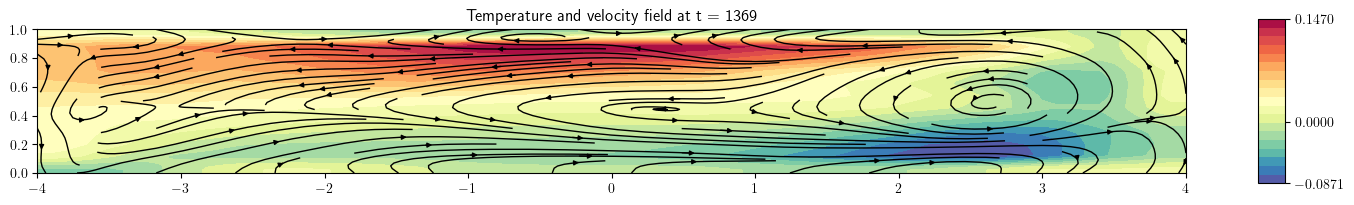

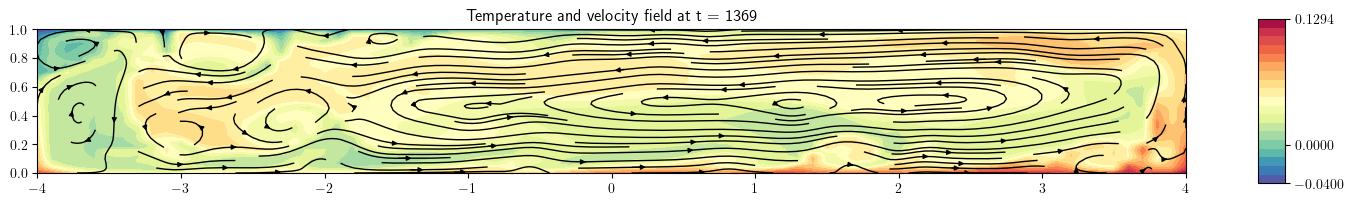

In [22]:
from data_analysis import Simulation
decoded_simulation = Simulation(current_directory, normalize = True)
decoded_simulation.reconstruct_simulation(decoded_data.cpu().numpy(), rgb = True)

t = 1369
decoded_simulation.plot_field(t)
simulation.plot_field(t)

In [25]:
decoded_simulation.save_clip(1350, 1400, f'{current_directory}/results/autoencoder/cnn/snapshots/')

from utils import make_gif

make_gif(f'{current_directory}/results/autoencoder/cnn/snapshots/', f'{current_directory}/results/gif/cnn_decoded_field_bs{batch_size}.gif', 10)

GIF created at: ..//results/gif/cnn_decoded_field_bs4.gif


In [34]:
uz_decoded, uzmean_decoded = decoded_simulation.UZ()
uz, uzmean = simulation.UZ()

In [36]:
print(time)

tensor([0.1000, 0.1006, 0.1013,  ..., 3.9982, 3.9988, 3.9995], device='cuda:0',
       dtype=torch.float64)


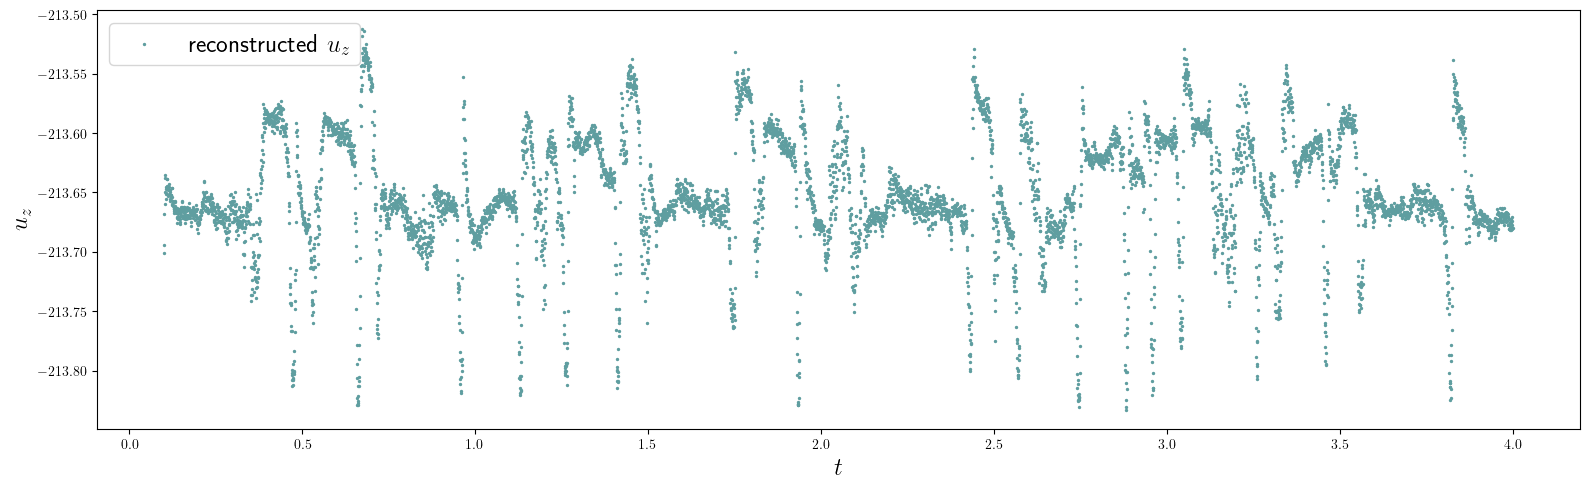

In [41]:
fig, ax1 = plt.subplots(figsize = (16, 5))


# ax1.scatter(time.cpu(), uz, s = 10, c = 'orange', label = r'ground truth $u_z$')
ax1.scatter(time.cpu(), uz_decoded + uzmean, s = 2, c = 'cadetblue', label = r'reconstructed $u_z$')

ax1.set_ylabel(r'$u_z$', fontsize= fontsize)
ax1.set_xlabel(r'$t$', fontsize = fontsize)
ax1.legend(fontsize = fontsize, loc = 'upper left')

fig.tight_layout()